<a href="https://colab.research.google.com/github/HediaBougi/Test/blob/master/Enron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [8]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
downloaded = drive.CreateFile({'id':'1B_QIq4rpKRNxdzummwuA3lCPjog1yn6n'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emails.csv') 

KeyboardInterrupt: ignored

In [92]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-09-30 18:13:01--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.99MB/s    in 1.5s    

2020-09-30 18:13:02 (9.99 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [94]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mallet-2.0.8/bin/classifier2info  
replace mallet-2.0.8/bin/csv2classify? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoostM2.cla

In [4]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=c54ff220f8d7895a73f154361acbf21f1e4e6da43b10e31d4677fc5c3ae79e54
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [5]:
import pandas as pd
import email
import re

import datetime as DT
from datetime import datetime

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [6]:
df = pd.read_csv('emails.csv')

FileNotFoundError: ignored

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.shape

(517401, 2)

In [5]:
print(df['message'][153])

Message-ID: <5063236.1075855690328.JavaMail.evans@thyme>
Date: Thu, 6 Jul 2000 09:38:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: Re: Thoughts on Presentation
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Tim,
 Matt sent you a email with his attempt to organize some of the cems and wscc 
data.  Tim H. expressed concern over the reliability of the wscc data.  I 
don't know if we should scrap the wscc or just keep monitoring in case it 
improves.  Let me know what you think.

Phillip


In [6]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    texts = []
    for txt in msg.walk():
        if txt.get_content_type() == 'text/plain':
            texts.append( txt.get_payload() )
    return ''.join(texts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addr = line.split(',')
        addr = frozenset(map(lambda x: x.strip(), addr))
    else:
        addr = None
    return addr

In [7]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['Content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['User'] = df['file'].map(lambda x:x.split('/')[0])
del messages

df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [8]:
print('Shape of the dataframe:', df.shape)

# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

Shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
Content 249025
User 150


In [9]:
df.dtypes

file                         object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
Content                      object
User                         object
dtype: object

In [10]:
# Set index and drop columns with two few values
df = df.set_index('Message-ID').drop(['Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [11]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

In [12]:
df.dtypes

file                       object
Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
Content                    object
User                       object
dtype: object

In [13]:
df

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User
Message-ID,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,allen-p/_sent_mail/1.,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,allen-p/_sent_mail/10.,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,allen-p/_sent_mail/100.,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,allen-p/_sent_mail/1000.,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,allen-p/_sent_mail/1001.,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
<26807948.1075842029936.JavaMail.evans@thyme>,zufferli-j/sent_items/95.,2001-11-28 21:30:11+00:00,(john.zufferli@enron.com),(kori.loibl@enron.com),Trade with John Lavorato,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Loibl, Kori </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,This is a trade with OIL-SPEC-HEDGE-NG (John L...,zufferli-j
<25835861.1075842029959.JavaMail.evans@thyme>,zufferli-j/sent_items/96.,2001-11-28 20:47:48+00:00,(john.zufferli@enron.com),(john.lavorato@enron.com),Gas Hedges,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,Some of my position is with the Alberta Term b...,zufferli-j
<28979867.1075842029988.JavaMail.evans@thyme>,zufferli-j/sent_items/97.,2001-11-28 15:20:00+00:00,(john.zufferli@enron.com),(dawn.doucet@enron.com),RE: CONFIDENTIAL,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Doucet, Dawn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,2\n\n -----Original Message-----\nFrom: \tDouc...,zufferli-j


Text(0, 0.5, 'Emails')

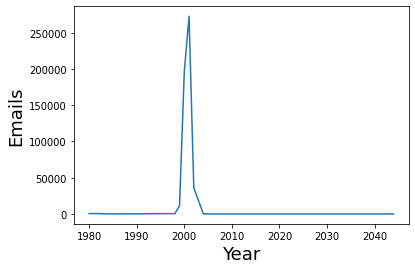

In [14]:
ax = df.groupby(df['Date'].dt.year)['Content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Emails', fontsize=18)

Text(0, 0.5, 'Emails')

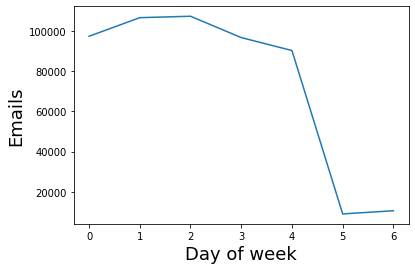

In [15]:
ax = df.groupby(df['Date'].dt.dayofweek)['Content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('Emails', fontsize=18)

In [16]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.dayofweek

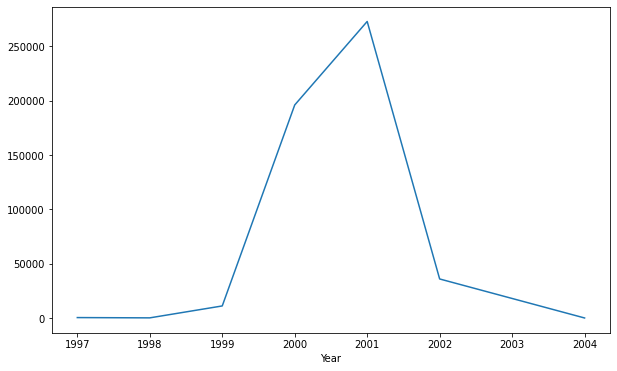

In [17]:
import matplotlib.pyplot as plt

indices = (df['Year'] > 1995) & (df['Year'] <= 2004)
plt.figure(figsize = (10,6))
figure1 = df.loc[indices].groupby('Year')['Content'].count().plot()

### Looks like the total number of emails really ramped up in 2000 and 2001

```
# This is formatted as code
```



In [18]:
df.Year.agg({'max': max, 'min': min})
#
df[df['Year']==2044]

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User,Month,Year,Day
Message-ID,,,,,,,,,,,,,,,,,
<21511287.1075842027020.JavaMail.evans@thyme>,zufferli-j/inbox/quotes/33.,2044-01-04 22:48:58+00:00,(cramer@cadvision.com),(john.zufferli@enron.com),trades,"""Erik Cramer"" <cramer@cadvision.com>@ENRON","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,"\nHowdy, \nbom went out 35 at 35.5 \nFeb trade...",zufferli-j,1,2044,0
<9293997.1075842027067.JavaMail.evans@thyme>,zufferli-j/inbox/quotes/35.,2044-01-04 16:59:46+00:00,(cramer@cadvision.com),(john.zufferli@enron.com),Trades,"""Erik Cramer"" <cramer@cadvision.com>@ENRON","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,"\nBOM 5th to 31st traded 34, 33.5 , 33.5 and ...",zufferli-j,1,2044,0
<15177697.1075842027136.JavaMail.evans@thyme>,zufferli-j/inbox/quotes/38.,2044-01-02 23:46:00+00:00,(cramer@cadvision.com),(john.zufferli@enron.com),trades jan 2002,"""Erik Cramer"" <cramer@cadvision.com>@ENRON","Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Inbox\Quotes",ZUFFERLI-J,john zufferli 6-26-02.PST,\nfeb dec trades 37.5 \nfeb dec LL went out 20...,zufferli-j,1,2044,5


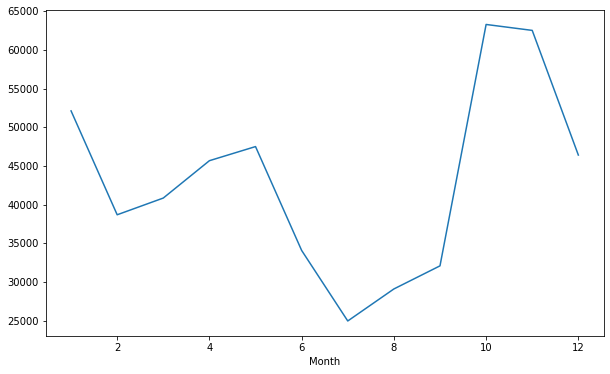

In [19]:
plt.figure(figsize = (10,6))
figure2 = df.groupby('Month')['Content'].count().plot()

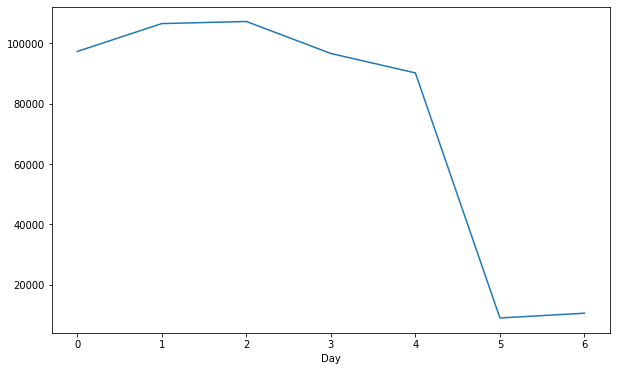

In [20]:
plt.figure(figsize = (10,6))
figure3 = df.groupby('Day')['Content'].count().plot()

In [21]:
# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

file 517401
Date 224122
From 20328
To 54748
Subject 159290
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
Content 249025
User 150
Month 12
Year 16
Day 7


In [22]:
top_10_frequent = df.groupby('User')['file'].count().sort_values(ascending = False)[:30]
top_10_frequent

User
kaminski-v       28465
dasovich-j       28234
kean-s           25351
mann-k           23381
jones-t          19950
shackleton-s     18687
taylor-m         13875
farmer-d         13032
germany-c        12436
beck-s           11830
symes-k          10827
nemec-g          10655
scott-s           8022
rogers-b          8009
bass-e            7823
sanders-r         7329
campbell-l        6490
shapiro-r         6071
guzman-m          6054
lay-k             5937
lenhart-m         5920
lokay-m           5568
kitchen-l         5546
haedicke-m        5246
sager-e           5200
love-p            5002
arnold-j          4898
fossum-d          4796
perlingiere-d     4778
lavorato-j        4685
Name: file, dtype: int64

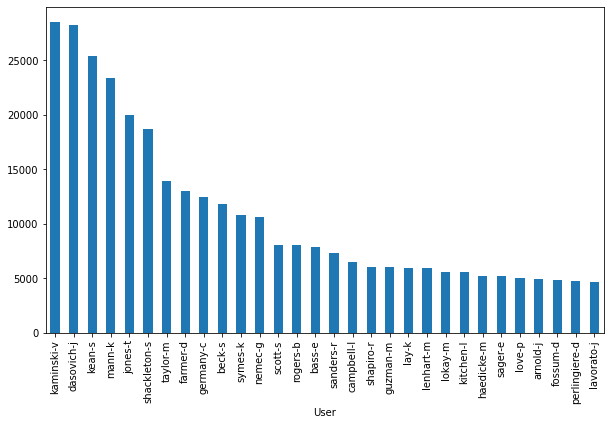

In [23]:
plt.figure(figsize = (10,6))
top_10_frequent.plot(kind = 'bar')

In [24]:
# Users and emails they sent by year
df.groupby(['User', 'Year'])['file'].count()[:39]

User        Year
allen-p     1980      10
            1999       8
            2000    1307
            2001    1704
            2002       5
arnold-j    1980       8
            2000    1832
            2001    3056
            2002       2
arora-h     1980       2
            2000      62
            2001     580
            2002      10
badeer-r    2000     851
            2001       2
            2002      24
bailey-s    2000       1
            2001     127
            2002     350
bass-e      1980       6
            1999      81
            2000    5727
            2001    1534
            2002     473
            2004       2
baughman-d  1980       6
            2000     176
            2001    2145
            2002     433
beck-s      1980      16
            1999      94
            2000    7235
            2001    4095
            2002     390
benson-r    2001     646
            2002     121
blair-l     2001    3409
            2002       6
brawner-s   1980       2
Name: fi

### Huge increase in emails numbers in 2000 and 2001

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
# Clean the Subject column

def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # Removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # Strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub('forwarded by phillip k allenhouect on    am', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('Subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['email_Subject'] = df['Subject'].apply(clean_column)
df['email_body'] = df['Content'].apply(clean_column)

<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence \[
<input>:13: DeprecationWarning: invalid escape sequence 

In [26]:
df['email_body'][135]

'from andy chen on   pm to michael etringerhouectect cc frank w vickershouectect saji johnhouectect phillip k  allenhouectect john arnoldhouectect  subject project elvis and cactus open gas position  mike  here are the net open socal border positions we have for elvis and cactus   lets try and set up a conference call with phillip and john to talk about  their offers at the backend of their curves  roughly speaking we are looking at a nominal  mmbtud for  years from  may  on elvis and  mmbtud on cactus fromjune  to april    andy'

In [27]:
df.head()

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User,Month,Year,Day,email_Subject,email_body
Message-ID,,,,,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,allen-p/_sent_mail/1.,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,5,2001,0,,here is our forecast
<15464986.1075855378456.JavaMail.evans@thyme>,allen-p/_sent_mail/10.,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,5,2001,4,,traveling to have a business meeting takes the...
<24216240.1075855687451.JavaMail.evans@thyme>,allen-p/_sent_mail/100.,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,10,2000,2,test,test successful way to go
<13505866.1075863688222.JavaMail.evans@thyme>,allen-p/_sent_mail/1000.,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,10,2000,0,,randy can you send me a schedule of the sala...
<30922949.1075863688243.JavaMail.evans@thyme>,allen-p/_sent_mail/1001.,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,8,2000,3,hello,lets shoot for tuesday at


In [28]:

stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'forwarded by phillip k allenhouect on    pm', 'cc', 'aa', 'aaa', 'aaaa', 'hou', 'wc', 'etc', 'subject', 'pm', 'enron', 'fwd', 'from']

for i in to_add:
    stopwords.add(i)

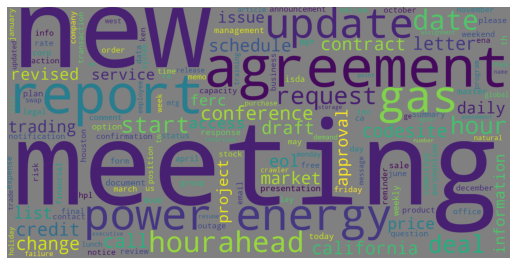

In [29]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='gray',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['email_Subject'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [31]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [32]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
sid = SentimentIntensityAnalyzer()

In [34]:
## Testing##
a = 'This was a good movie.'
sid.polarity_scores(a)

{'compound': 0.4404, 'neg': 0.0, 'neu': 0.508, 'pos': 0.492}

In [35]:
a = 'This was the best, most awesome movie EVER MADE!!!'
sid.polarity_scores(a)

{'compound': 0.8877, 'neg': 0.0, 'neu': 0.425, 'pos': 0.575}

In [36]:
df['email_body'][135]

'from andy chen on   pm to michael etringerhouectect cc frank w vickershouectect saji johnhouectect phillip k  allenhouectect john arnoldhouectect  subject project elvis and cactus open gas position  mike  here are the net open socal border positions we have for elvis and cactus   lets try and set up a conference call with phillip and john to talk about  their offers at the backend of their curves  roughly speaking we are looking at a nominal  mmbtud for  years from  may  on elvis and  mmbtud on cactus fromjune  to april    andy'

In [37]:
df['scores'] = df['email_body'].apply(lambda email_body: sid.polarity_scores(email_body))
df.head()

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User,Month,Year,Day,email_Subject,email_body,scores
Message-ID,,,,,,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,allen-p/_sent_mail/1.,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,5,2001,0,,here is our forecast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
<15464986.1075855378456.JavaMail.evans@thyme>,allen-p/_sent_mail/10.,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,5,2001,4,,traveling to have a business meeting takes the...,"{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'comp..."
<24216240.1075855687451.JavaMail.evans@thyme>,allen-p/_sent_mail/100.,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,10,2000,2,test,test successful way to go,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp..."
<13505866.1075863688222.JavaMail.evans@thyme>,allen-p/_sent_mail/1000.,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,10,2000,0,,randy can you send me a schedule of the sala...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
<30922949.1075863688243.JavaMail.evans@thyme>,allen-p/_sent_mail/1001.,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,8,2000,3,hello,lets shoot for tuesday at,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp..."


### The Compound score 
The coumpound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between 
- -1(most extreme negative) and 
- +1 (most extreme positive).
----------------------------------------------------
- positive sentiment : (compound score >= 0.05)
- neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
- negative sentiment : (compound score <= -0.05)

In [38]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User,Month,Year,Day,email_Subject,email_body,scores,compound
Message-ID,,,,,,,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,allen-p/_sent_mail/1.,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,5,2001,0,,here is our forecast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
<15464986.1075855378456.JavaMail.evans@thyme>,allen-p/_sent_mail/10.,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,5,2001,4,,traveling to have a business meeting takes the...,"{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'comp...",0.9313
<24216240.1075855687451.JavaMail.evans@thyme>,allen-p/_sent_mail/100.,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,10,2000,2,test,test successful way to go,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859
<13505866.1075863688222.JavaMail.evans@thyme>,allen-p/_sent_mail/1000.,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,10,2000,0,,randy can you send me a schedule of the sala...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
<30922949.1075863688243.JavaMail.evans@thyme>,allen-p/_sent_mail/1001.,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,8,2000,3,hello,lets shoot for tuesday at,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400


In [55]:
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0.5 else ('neutr' if 0<=c<0.05  else 'neg'))

df.head()

,file,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Content,User,Month,Year,Day,email_Subject,email_body,scores,compound,comp_score
Message-ID,,,,,,,,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,allen-p/_sent_mail/1.,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,5,2001,0,,here is our forecast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutr
<15464986.1075855378456.JavaMail.evans@thyme>,allen-p/_sent_mail/10.,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,5,2001,4,,traveling to have a business meeting takes the...,"{'neg': 0.0, 'neu': 0.886, 'pos': 0.114, 'comp...",0.9313,pos
<24216240.1075855687451.JavaMail.evans@thyme>,allen-p/_sent_mail/100.,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,10,2000,2,test,test successful way to go,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.5859,pos
<13505866.1075863688222.JavaMail.evans@thyme>,allen-p/_sent_mail/1000.,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,10,2000,0,,randy can you send me a schedule of the sala...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutr
<30922949.1075863688243.JavaMail.evans@thyme>,allen-p/_sent_mail/1001.,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,8,2000,3,hello,lets shoot for tuesday at,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",-0.3400,neg


In [1]:
df.to_csv(Ennron, sep='\t', encoding='utf-8')

NameError: ignored

In [2]:
df

NameError: ignored

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
#df['email_body'].apply(word_tokenize)

In [52]:
# Convert email body to list
data = df.email_body.values.tolist()

In [53]:
for lines in data[:50]: 
        print(lines)
        scores = sid.polarity_scores(lines)
        for key in sorted(scores):
                print('{0}: {1}, '.format(key, scores[key]), end='')
        print()

here is our forecast
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
traveling to have a business meeting takes the fun out of the trip  especially if you have to prepare a presentation  i would suggest holding the business plan meetings here then take a trip without any formal business meetings  i would even try and get some honest opinions on whether a trip is even desired or necessary  as far as the business meetings i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not  too often the presenter speaks and the others are quiet just waiting for their turn   the meetings might be better if held in a round table discussion format    my suggestion for where to go is austin  play golf and rent a ski boat and jet skis  flying somewhere takes too much time
compound: 0.9313, neg: 0.0, neu: 0.886, pos: 0.114, 
test successful  way to go
compound: 0.5859, neg: 0.0, neu: 0.513, pos: 0.487, 
randy   can you send me a 

#Topics Labeling

In [72]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [62]:
# tokenize - break down each sentence into a list of words
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sentence_to_words(data[:1000]))
print(data_words[10])

['mr', 'buckner', 'for', 'delivered', 'gas', 'behind', 'san', 'diego', 'enron', 'energy', 'services', 'is', 'the', 'appropriate', 'enron', 'entity', 'have', 'forwarded', 'your', 'request', 'to', 'zarin', 'imam', 'at', 'ees', 'her', 'phone', 'number', 'is', 'phillip', 'allen']


In [63]:
# Build the bigram and trigram models
# Higher threshold fewer phrases
bigram = Phrases(data_words, min_count=5, threshold=100) 
trigram = Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[200]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'julie', 'gomez', 'am', 'to', 'hunter', 'phillip', 'allenhouectect', 'cc', 'subject', 'alliance', 'netback', 'worksheet', 'hello', 'men', 'have', 'attached', 'my', 'worksheet', 'in', 'case', 'you', 'want', 'to', 'review', 'the', 'data', 'while', 'am', 'on', 'holiday', 'thanks', 'julie']


In [64]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [73]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [75]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [77]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [78]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [79]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [80]:
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

##Topic Modeling — Gensim LDA Model

In [87]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [82]:
print(lda_model.print_topics())

[(0, '0.024*"want" + 0.024*"may" + 0.024*"plant" + 0.021*"go" + 0.019*"way" + 0.019*"new" + 0.018*"look" + 0.017*"would" + 0.017*"find" + 0.016*"work"'), (1, '0.043*"pm" + 0.035*"meeting" + 0.035*"response" + 0.033*"phillip" + 0.030*"tomorrow" + 0.027*"send" + 0.026*"work" + 0.023*"start" + 0.023*"quote" + 0.023*"notice"'), (2, '0.030*"value" + 0.027*"buyer" + 0.023*"activity" + 0.020*"time" + 0.019*"pay" + 0.018*"post" + 0.018*"fee" + 0.017*"cash" + 0.017*"purchase" + 0.015*"contract"'), (3, '0.048*"cost" + 0.043*"would" + 0.030*"project" + 0.021*"construction" + 0.021*"loan" + 0.016*"land" + 0.014*"estimate" + 0.013*"profit" + 0.012*"investment" + 0.011*"late"'), (4, '0.052*"power" + 0.026*"demand" + 0.024*"state" + 0.020*"comment" + 0.019*"increase" + 0.018*"load" + 0.018*"could" + 0.015*"free" + 0.015*"however" + 0.010*"reduction"'), (5, '0.041*"gas" + 0.035*"thank" + 0.031*"call" + 0.030*"phillip" + 0.029*"request" + 0.027*"help" + 0.026*"forward" + 0.023*"trading" + 0.023*"line" 

In [83]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

## Model Perplexity And Coherence

In [86]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.13041195208358


In [88]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.36429209116035915


##Topic Modeling 2.0 — Mallet LDA Model

In [95]:
mallet_path = 'mallet-2.0.8/bin/mallet' 

In [96]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [97]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

[(2, [('gas', 0.1043115438108484), ('call', 0.04728789986091794), ('tomorrow', 0.0368567454798331), ('time', 0.034075104311543813), ('forward', 0.03337969401947149), ('discuss', 0.02851182197496523), ('table', 0.02573018080667594), ('work', 0.02364394993045897), ('make', 0.022253129346314324), ('give', 0.022253129346314324)]), (8, [('price', 0.056524773203070484), ('power', 0.05024424284717376), ('high', 0.021284019539427775), ('sell', 0.020237264480111653), ('fall', 0.019190509420795535), ('today', 0.016399162595952546), ('plant', 0.0157013258897418), ('unit', 0.0157013258897418), ('market', 0.0157013258897418), ('iso', 0.013956734124214934)]), (12, [('check', 0.06431535269709543), ('risk', 0.028354080221300138), ('report', 0.02351313969571231), ('account', 0.022130013831258646), ('service', 0.021438450899031812), ('future', 0.021438450899031812), ('notice', 0.020055325034578148), ('agreement', 0.020055325034578148), ('detail', 0.017980636237897647), ('architect', 0.01590594744121715)

In [98]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4024838837461253


In [101]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [102]:
# run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


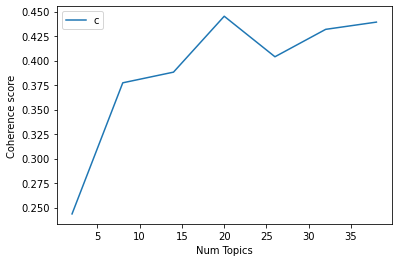

In [103]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [104]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.2435
Num Topics = 8  has Coherence Value of 0.3773
Num Topics = 14  has Coherence Value of 0.3882
Num Topics = 20  has Coherence Value of 0.4453
Num Topics = 26  has Coherence Value of 0.4039
Num Topics = 32  has Coherence Value of 0.4319
Num Topics = 38  has Coherence Value of 0.4393


In [105]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))


[(23, '0.062*"project" + 0.035*"site" + 0.029*"week" + 0.025*"property" + 0.020*"require" + 0.019*"lot" + 0.017*"back" + 0.017*"discuss" + 0.015*"current" + 0.014*"deal"'), (16, '0.058*"position" + 0.030*"issue" + 0.024*"project" + 0.022*"deal" + 0.020*"ability" + 0.020*"trader" + 0.019*"requirement" + 0.018*"option" + 0.018*"show" + 0.018*"change"'), (21, '0.108*"phillip" + 0.096*"meeting" + 0.072*"pm" + 0.069*"send" + 0.056*"start" + 0.033*"description" + 0.031*"weekend" + 0.029*"accept" + 0.024*"end" + 0.022*"response"'), (10, '0.056*"cost" + 0.039*"leave" + 0.031*"number" + 0.029*"schedule" + 0.028*"call" + 0.025*"profit" + 0.023*"builder" + 0.022*"build" + 0.021*"mention" + 0.019*"closing"'), (24, '0.081*"price" + 0.034*"high" + 0.034*"power" + 0.026*"today" + 0.025*"fall" + 0.024*"trader" + 0.023*"forecast" + 0.022*"low" + 0.021*"trade" + 0.017*"sell"'), (14, '0.069*"loan" + 0.048*"cost" + 0.032*"land" + 0.025*"construction" + 0.020*"fee" + 0.019*"improvement" + 0.014*"investor" 

In [108]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [109]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [110]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [111]:
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.0530,"price, high, power, today, fall, trader, forec...",here is our forecast
1,1,21.0,0.4159,"phillip, meeting, pm, send, start, description...",traveling to have a business meeting takes the...
2,2,11.0,0.0464,"offer, risk, set, make, term, program, money, ...",test successful way to go
3,3,7.0,0.0771,"call, work, phillip, time, tomorrow, manager, ...",randy can you send me a schedule of the sala...
4,4,0.0,0.0385,"note, access, outlook, web, mail, instruction,...",lets shoot for tuesday at
5,5,0.0,0.0385,"note, access, outlook, web, mail, instruction,...",greg how about either next tuesday or thursd...
6,6,0.0,0.0510,"note, access, outlook, web, mail, instruction,...",please cc the following distribution list with...
7,7,4.0,0.0486,"power, plant, iso, unit, line, sell, pay, repo...",any morning between and
8,8,6.0,0.0572,"email, information, send, receive, complete, f...",login pallen pw kedavis i dont think these ...
9,9,5.0,0.2559,"gas, price, forward, market, begin, natural, a...",buckner buck buckbucknerhoneywellcom on pm t...


In [112]:
df_dominant_topic.Keywords.iloc[1]

'phillip, meeting, pm, send, start, description, weekend, accept, end, response'

In [113]:
df_dominant_topic.Text.iloc[1]

'traveling to have a business meeting takes the fun out of the trip  especially if you have to prepare a presentation  i would suggest holding the business plan meetings here then take a trip without any formal business meetings  i would even try and get some honest opinions on whether a trip is even desired or necessary  as far as the business meetings i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not  too often the presenter speaks and the others are quiet just waiting for their turn   the meetings might be better if held in a round table discussion format    my suggestion for where to go is austin  play golf and rent a ski boat and jet skis  flying somewhere takes too much time'

In [114]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [115]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [116]:
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [117]:
# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7132,"note, access, outlook, web, mail, instruction,...",outlook migration teamenron pm to allison ho...
1,1.0,0.3958,"unit, project, cash, cost, total, due, agreeme...",george richards cbpresaustinrrcom on pm plea...
2,2.0,0.3845,"file, phillip, attach, follow, today, good, em...",al i was glad to hear from you i hope we can...
3,3.0,0.6085,"change, time, show, storage, deal, people, quo...",from colleen sullivan ...
4,4.0,0.8559,"power, plant, iso, unit, line, sell, pay, repo...",jeff richter am to phillip k allenhouectect ...
5,5.0,0.6065,"gas, price, forward, market, begin, natural, a...",from jennifer fraser ...
6,6.0,0.5747,"email, information, send, receive, complete, f...",christi smith christismithlrinetcom on am pl...
7,7.0,0.3240,"call, work, phillip, time, tomorrow, manager, ...",to faith killenhouectect cc subject west ga...
8,8.0,0.7990,"utility, company, power, business, energy, mon...",jeff richter am to phillip k allenhouectect ...
9,9.0,0.6948,"trade, gas, physical, index, spread, financial...",liane as we discussed yesterday i am concern...
